# Cuestionario 4

Autor: Sergio Santiago Sánchez

Durante el siguiente estudio trateremos de diseñar una red que sea capaz de determinar cuando una persona tiene sobrepeso, diferenciando entre diversos grados, mediante una serie de caracteristicas. El dataset usado para el entrenamiento puede encontrarse [aqui](https://archive.ics.uci.edu/dataset/544/estimation+of+obesity+levels+based+on+eating+habits+and+physical+condition)

Usaremos las siguientes librerías:
* [Scikit-learn](https://scikit-learn.org/stable/)
* [Numpy](https://numpy.org/)
* [Pandas](https://pandas.pydata.org/)
* [Matplotlib](https://matplotlib.org/)
* [Seaborn](https://seaborn.pydata.org/)

Intalamos e importamos las librerias necesarias:

In [314]:
pip install -r requirements.txt


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


Tal y como se sugiere en la asignatura haremos uso de una versión modificada de la librería `mglearn`. Desafortunadamente, emplear esta librería nos obliga a modificar la versión de `joblib`, estableciendo esta en la 1.1.1, por lo que debido a otra imcompatibilidad debemos usar `numpy` con la versión 1.26.4, y `scikit-learn` con la versión `1.3.2`. Todas las instalaciones necesarios estan presentes en el archivo `requirements.txt`.

In [315]:
import mglearn

In [347]:
import math
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler, RobustScaler
import pandas as pd
from scipy import stats
import numpy as np
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA

### Cargamos los datos y hacemos un estudio exploratorio preliminar

In [317]:
data = pd.read_csv("./data/ObesityDataSet_raw_and_data_sinthetic.csv",)

In [318]:
display(data.head())

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


En este caso, la variable objetivo es representada por la primera columna `"NObeyesdad"`, representa el grado de obesidad de la persona. El resto son variables que permiten describir las distintas caracteristicas de cada instancia.

| **Nombre en Inglés**                     | **Traducción al Español**               |
|------------------------------------------|-----------------------------------------|
| Gender                                   | Género                                  |
| Age                                      | Edad                                    |
| Height                                   | Altura                                  |
| Weight                                   | Peso                                    |
| family_history_with_overweight           | Antecedentes familiares de sobrepeso    |
| FAVC                                     | Frecuencia de consumo de alimentos hipercalóricos |
| FCVC                                     | Consumo de verduras por comida         |
| NCP                                      | Número de comidas principales al día    |
| CAEC                                     | Frecuencia de consumo de comida entre comidas |
| SMOKE                                    | Fuma                                    |
| CH2O                                     | Consumo diario de agua (litros)         |
| SCC                                      | Monitoreo del consumo de calorías       |
| FAF                                      | Actividad física frecuente (días por semana) |
| TUE                                      | Tiempo de uso de dispositivos electrónicos (horas/día) |
| CALC                                     | Frecuencia de consumo de alcohol        |
| MTRANS                                   | Medio de transporte habitual            |
| NObeyesdad                               | Nivel de obesidad                       |


A continuación exploraremos las distintas posibilidades para cada propiedad, para de este modo llevar a cabo una estrategia u otra. Ya que por ejemplo, si hablamos de variables categóricas que implican un cierto orden, podriamos sustituir los valores por enteros, por el contraria, si las variables no reflejan ningún tipo de orden podríamos optar por usar [`one hot`](https://interactivechaos.com/es/manual/tutorial-de-machine-learning/one-hot-encoding).

La técnica de one hot, consiste en añadir una columna al dataset por cada posibilidad de la variable a reemplazar. En cada instancia de los datos asignaremos un 0 en aquellas columnas extra que no coincidan con su valor original y un 1 en aquella que si represente la asignación original.

Usar una técnica u otra ayuda al modelo a no malinterpretar relaciones, ya que si sustituimos siempre por valores numéricos podría llegar a pensar que una cualidad esta por encima de otra. Por otro lado, si siempre aplicamos one hot, privamos al modelo de aprender esa posible relación en los casos en los que sí tenga sentido.

Dado que el dataset contiene algunas variables que representan valores continuos, limitaremos el número de salidas a mostrar, de este modo facilitamos la visualización de los datos. Para saber si estamos obviando algun dato que no sea continuo representamos también el número total de casos únicos que contiene.

In [319]:
for col in data.columns:
    print( f" -- Column {col:<35} (count: {len(data[col].unique()):5}): {data[col].unique()[:7]}")

 -- Column Gender                              (count:     2): ['Female' 'Male']
 -- Column Age                                 (count:  1402): [21. 23. 27. 22. 29. 24. 26.]
 -- Column Height                              (count:  1574): [1.62 1.52 1.8  1.78 1.5  1.64 1.72]
 -- Column Weight                              (count:  1525): [64.  56.  77.  87.  89.8 53.  55. ]
 -- Column family_history_with_overweight      (count:     2): ['yes' 'no']
 -- Column FAVC                                (count:     2): ['no' 'yes']
 -- Column FCVC                                (count:   810): [2.       3.       1.       2.450218 2.880161 2.00876  2.596579]
 -- Column NCP                                 (count:   635): [3.       1.       4.       3.28926  3.995147 1.72626  2.581015]
 -- Column CAEC                                (count:     4): ['Sometimes' 'Frequently' 'Always' 'no']
 -- Column SMOKE                               (count:     2): ['no' 'yes']
 -- Column CH2O                       

Como podemos observar, las variables Age, Height, Weight, FCVC (frecuencia con que come verduras), NCP (número de comidas), CH2O (cuanta agua beben diariamente), FAF (frecuencia con la que hacen actividad física), TUE (cuánto tiempo dediacan al uso de dispositivos electrónicos), CALC (frecuencia del consumo del alcohol) y MTRANS (medio de transporte más frecuente) presentan valores continuos

Tras ojear los datos hay algunos valores que pueden llegar a parecer extraños, como por ejemplo, para la edad, la frecuencia con la que introducen verduras en las comidas, los niveles de agua o el tiempo dedicado a dispositivos electrónicos. Esto se debe a que un gran número de los datos se han generado de forma artificial, por lo que para proporcionar información algo más cercana a la realidad (dado el contesto), vamos a redondear los datos.

In [320]:
data_rounded = data.copy()

data_rounded["Age"] = data["Age"].map(lambda a: round(a))
data_rounded["FCVC"] = data["FCVC"].map(lambda a: round(a))
data_rounded["NCP"] = data["NCP"].map(lambda a: round(a))
data_rounded["CH2O"] = data["CH2O"].map(lambda a: round(a, 1))
data_rounded["FAF"] = data["FAF"].map(lambda a: round(a))
data_rounded["TUE"] = data["TUE"].map(lambda a: round(a, 1))

Ahora vamos a sustituir la variables que indican tiempo por números enteros, para que la red pueda aprender esa relación temporal. Haremos lo mismo para las variables que interpretan aceptación o negación (si o no) y con los distintos tipos de obesidades. 

In [321]:
temporal_map = {
    "no": 0,
    "Sometimes": 1,
    "Frequently": 2,
    "Always": 3
}

affirmation_map = {
    "no": 0,
    "yes": 1
}
 
obesity_map = {
     "Insufficient_Weight": 0,
     "Normal_Weight": 1,
     "Overweight_Level_I": 2,
     "Overweight_Level_II": 3,
     "Obesity_Type_I": 4,
     "Obesity_Type_II": 5,
     "Obesity_Type_III": 6
 }

data_mapped = data_rounded.copy()

data_mapped["CAEC"] = data["CAEC"].map(temporal_map)
data_mapped["CALC"] = data["CALC"].map(temporal_map)
data_mapped["family_history_with_overweight"] = data["family_history_with_overweight"].map(affirmation_map)
data_mapped["FAVC"] = data["FAVC"].map(affirmation_map)
data_mapped["SMOKE"] = data["SMOKE"].map(affirmation_map)
data_mapped["SCC"] = data["SCC"].map(affirmation_map)
data_mapped["NObeyesdad"] = data["NObeyesdad"].map(obesity_map)

Para el resto de variables no numéricas vamos a aplicar one hot.

In [322]:
data_mapped = pd.get_dummies(data_mapped, columns=["Gender", "MTRANS"], dtype=int)

In [323]:
for col in data_mapped.columns:
    print( f" -- Column {col:<35} (count: {len(data_mapped[col].unique()):5}): {data_mapped[col].unique()[:10]}")

 -- Column Age                                 (count:    40): [21 23 27 22 29 24 26 41 30 52]
 -- Column Height                              (count:  1574): [1.62 1.52 1.8  1.78 1.5  1.64 1.72 1.85 1.65 1.77]
 -- Column Weight                              (count:  1525): [ 64.   56.   77.   87.   89.8  53.   55.   68.  105.   80. ]
 -- Column family_history_with_overweight      (count:     2): [1 0]
 -- Column FAVC                                (count:     2): [0 1]
 -- Column FCVC                                (count:     3): [2 3 1]
 -- Column NCP                                 (count:     4): [3 1 4 2]
 -- Column CAEC                                (count:     4): [1 2 3 0]
 -- Column SMOKE                               (count:     2): [0 1]
 -- Column CH2O                                (count:    21): [2.  3.  1.  1.2 1.1 2.7 2.2 2.4 2.8 2.9]
 -- Column SCC                                 (count:     2): [0 1]
 -- Column FAF                                 (count:     4): [0 3

Debemos aplicar una estadarización de los datos de tal forma que no tengan mayor importancia unos datos que otros, para ello podemos usar [`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) permite mantener una media de 0 y una desviación estandar de 1, con lo que conseguimos tratar a todos los valores por igual.

In [324]:
#scaler = StandardScaler()
#columns_to_scale = ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CAEC', 'CH2O', 'FAF', 'TUE', 'CALC']
#data_mapped[columns_to_scale] = scaler.fit_transform(data_mapped[columns_to_scale])


## Entrenando la red

El siguiente paso es entrenar una red neuronal para poder realizar predicciones. Para ello debemos sepaar el conjunto de datos en entrenamiento y pruebas. En primer lugar debemos separar los datos según son variables del posible modelo o características a predecir.

In [325]:
x_data = data_mapped.drop(columns=["NObeyesdad"])
y_data = data_mapped[["NObeyesdad"]]

In [326]:
display(x_data.head())
display(y_data.head())

,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,...,FAF,TUE,CALC,Gender_Female,Gender_Male,MTRANS_Automobile,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking
0,21,1.62,64.0,1,0,2,3,1,0,2.0,...,0,1.0,0,1,0,0,0,0,1,0
1,21,1.52,56.0,1,0,3,3,1,1,3.0,...,3,0.0,1,1,0,0,0,0,1,0
2,23,1.80,77.0,1,0,2,3,1,0,2.0,...,2,1.0,2,0,1,0,0,0,1,0
3,27,1.80,87.0,0,0,3,3,1,0,2.0,...,2,0.0,2,0,1,0,0,0,0,1
4,22,1.78,89.8,0,0,2,1,1,0,2.0,...,0,0.0,1,0,1,0,0,0,1,0


,NObeyesdad
0,1
1,1
2,1
3,2
4,3


Mediante el método [train_test_split](https://scikit-learn.org/1.5/modules/generated/sklearn.model_selection.train_test_split.html) realizamos una división del dataset en dos conjuntos, entrenamiento y pruebas.

In [327]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.3, random_state=557)

In [328]:
scaler = StandardScaler()
columns_to_scale = ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CAEC', 'CH2O', 'FAF', 'TUE', 'CALC']
x_train_scaled = pd.DataFrame(scaler.fit_transform(x_train))

x_test_scaled = pd.DataFrame(scaler.transform(x_test))

Debido a que los outliers podrían afectar gravemente al entrenamiento de la red, probaremos tambien a escalar los datos con [`RobustScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html#sklearn.preprocessing.RobustScaler), ya que al aplicar un rango basado en cuantiles evita que los outliers afecten al resto de valores.

In [329]:
robust_scaler = RobustScaler()
x_train_robust_scaled = pd.DataFrame(scaler.fit_transform(x_train))
x_test_robust_scaled = pd.DataFrame(scaler.transform(x_test))

x_data_robust_scaled = pd.DataFrame(scaler.transform(x_data))

Definimos una función que nos permita entrenar modelos con distintos hiperparámetros de form sencilla. Para entrenar la red usaremos [`MLPClassifier`](https://scikit-learn.org/1.5/modules/generated/sklearn.neural_network.MLPClassifier.html) de la librería de Scikit-learn.

In [330]:
def develop_net(f_act, layers, x_train_data: pd.DataFrame = x_train_scaled, y_train_data: pd.DataFrame = y_train, x_test_data: pd.DataFrame = x_test_scaled, y_test_data: pd.DataFrame = y_test):    
    x_data_total = pd.concat([x_train_data, x_test_data], axis=0)
    y_data_total = pd.concat([y_train_data, y_test_data], axis=0)
    
    y_train_data = y_train_data.values.ravel()
    y_test_data = y_test_data.values.ravel()
    y_data_total = y_data_total.values.ravel()
    
    print(f"\ntrain data shape:  x -> {x_train_data.shape} y -> {y_train_data.shape}")
    print(f"test data shape:  x -> {x_test_data.shape} y -> {y_test_data.shape}")
    print(f"total data shape:  x -> {x_data_total.shape} y -> {y_data_total.shape}")
    
    mlp_model = MLPClassifier(solver='lbfgs',
                               random_state=0,
                               hidden_layer_sizes=layers,
                               activation=f_act,
                               max_iter=2000)
    mlp_model.fit(x_train_data, y_train_data)
    
    y_test_pred = mlp_model.predict(x_test_data)
    
   
    print("Train dataset performance: ",mlp_model.score(x_train_data,y_train_data))
    print("Test dataset performance: ",mlp_model.score(x_test_data,y_test_data))
    print("Total dataset performance: ",mlp_model.score(x_data_total,y_data_total))
    
    return mlp_model

In [331]:
develop_net('relu',(4,4,))
original_net = develop_net('relu',(4,4,), x_train_robust_scaled, y_train, x_test_robust_scaled, y_test)


train data shape:  x -> (1477, 21) y -> (1477,)
test data shape:  x -> (634, 21) y -> (634,)
total data shape:  x -> (2111, 21) y -> (2111,)
Train dataset performance:  0.983750846310088
Test dataset performance:  0.9542586750788643
Total dataset performance:  0.9748934154429181

train data shape:  x -> (1477, 21) y -> (1477,)
test data shape:  x -> (634, 21) y -> (634,)
total data shape:  x -> (2111, 21) y -> (2111,)
Train dataset performance:  0.983750846310088
Test dataset performance:  0.9542586750788643
Total dataset performance:  0.9748934154429181


## Análisis PCA

Con el objetivo de mejorar el entrenamiento vamos a realizar un analisis PCA, ya que este permite identificar los componentes principales, para de este modo eliminar todas aquellas características que carecen de valor para el entrenamiento.

In [332]:
pca = PCA(n_components=len(x_data_robust_scaled.columns))
pca_data = pca.fit_transform(x_data_robust_scaled)

Tras haber calculado PCA, mostraremos mediante un gráfico de barras la proporción de la varianza total explicada (almacenada en `explained_variance_ratio_`), es decir, indicaremos mediante el gráfico cómo de importantes son las distintas variables dentro del dataset.

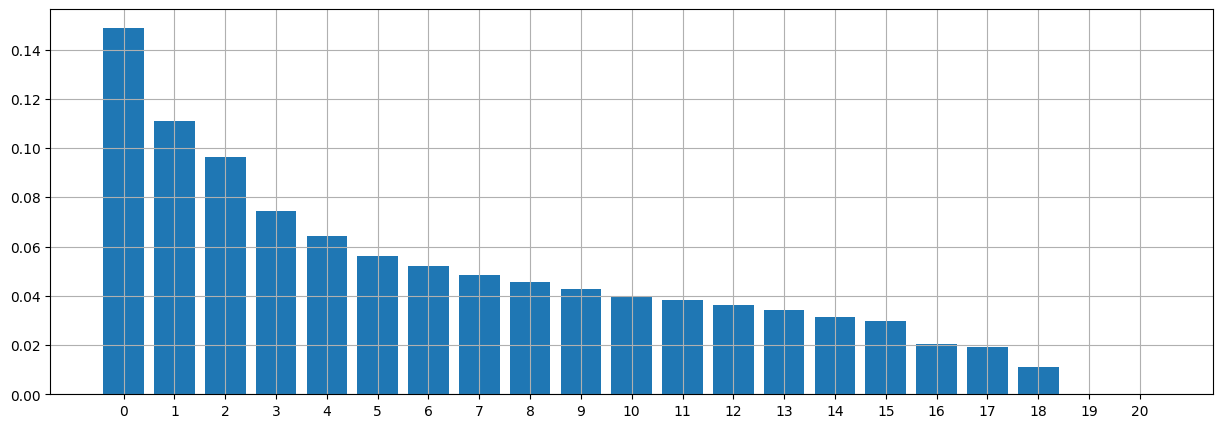

In [333]:
plt.figure(figsize=(15,5))
plt.bar(range(pca_data.shape[1]) ,pca.explained_variance_ratio_)
plt.xticks(range(pca_data.shape[1]))
plt.grid(True)
plt.show()

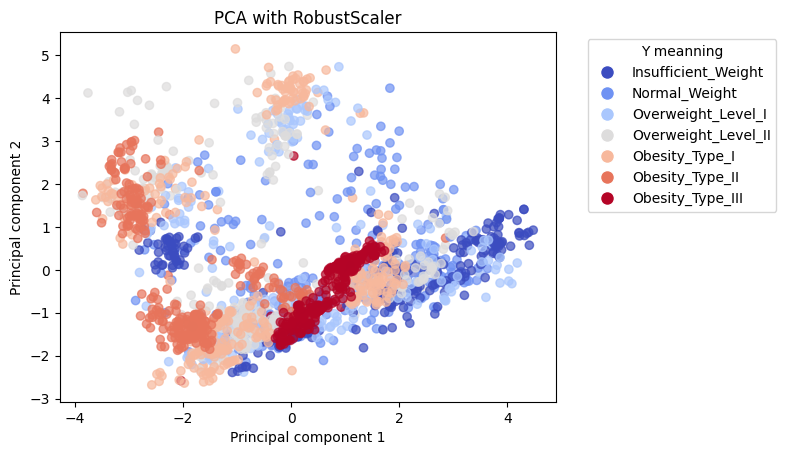

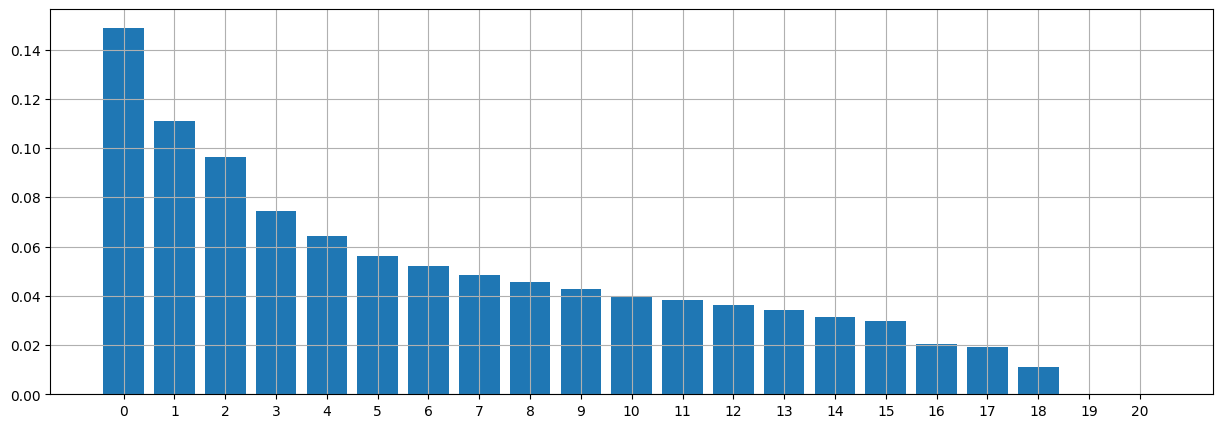

In [334]:
obesity_map_legend = {
    0: "Insufficient_Weight",
    1: "Normal_Weight",
    2: "Overweight_Level_I",
    3: "Overweight_Level_II",
    4: "Obesity_Type_I",
    5: "Obesity_Type_II",
    6: "Obesity_Type_III"
}

scatter = plt.scatter(pca_data[:, 0], pca_data[:, 1], c=y_data.values, cmap='coolwarm', alpha=0.7)
plt.title("PCA with RobustScaler")
plt.xlabel("Principal component 1")
plt.ylabel("Principal component 2")
#plt.colorbar(label="Y value")
handles = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter.cmap(scatter.norm(label)), markersize=10)
    for label in obesity_map_legend.keys()
]
labels = [obesity_map_legend[label] for label in obesity_map_legend.keys()]
plt.legend(handles, labels, title="Y meanning", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

plt.figure(figsize=(15,5))
plt.bar(range(pca_data.shape[1]) ,pca.explained_variance_ratio_)
plt.xticks(range(pca_data.shape[1]))
plt.grid(True)
plt.show()

Habiendo calculado PCA podemos afirmar que los datos relevantes se encuentran en los 18 primeros componentes, por ello entrenaremos la red con estas varibales, para de este modo no introducir información irrelevante a la red. 

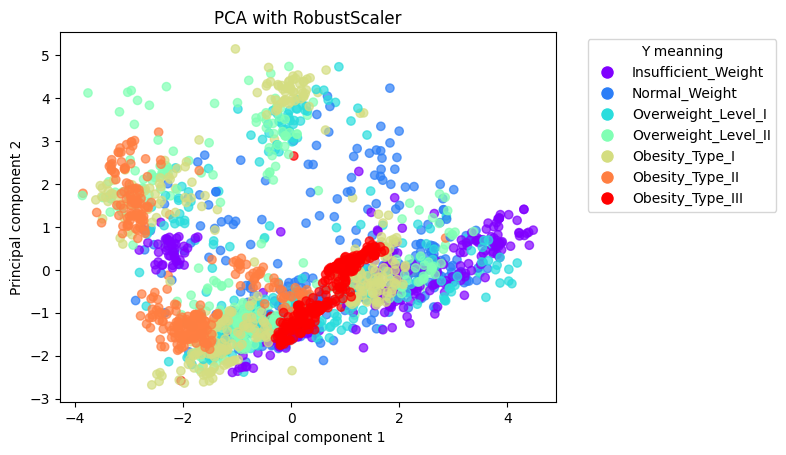

In [335]:
pca = PCA(n_components=19)
pca_data = pca.fit_transform(x_data_robust_scaled)

obesity_map_legend = {
    0: "Insufficient_Weight",
    1: "Normal_Weight",
    2: "Overweight_Level_I",
    3: "Overweight_Level_II",
    4: "Obesity_Type_I",
    5: "Obesity_Type_II",
    6: "Obesity_Type_III"
}

scatter = plt.scatter(pca_data[:, 0], pca_data[:, 1], c=y_data.values, cmap='rainbow', alpha=0.7)
plt.title("PCA with RobustScaler")
plt.xlabel("Principal component 1")
plt.ylabel("Principal component 2")
#plt.colorbar(label="Y value")
handles = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter.cmap(scatter.norm(label)), markersize=10)
    for label in obesity_map_legend.keys()
]
labels = [obesity_map_legend[label] for label in obesity_map_legend.keys()]
plt.legend(handles, labels, title="Y meanning", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

In [336]:
pca_data_df = pd.DataFrame(pca_data)
x_train_pca, x_test_pca, y_train_pca, y_test_pca = train_test_split(pca_data_df, y_data, test_size=0.3, random_state=557)

display(x_train_pca.head())

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
865,4.181053,0.158638,1.370481,-0.679994,-0.454036,0.854745,0.199414,-0.598218,2.320186,-1.512164,1.638292,1.573393,-2.861175,1.294956,-0.134947,-0.373804,0.743168,0.575618,0.915782
1831,0.996794,-0.290332,-1.823715,0.714089,0.506659,0.134910,0.453070,-0.605800,-0.590551,0.598877,0.372325,-0.713661,-0.677605,0.830917,-0.006114,0.574207,-0.092740,-0.324891,0.600949
585,2.333062,-0.434542,0.471543,-0.559971,-1.047472,0.610463,0.625630,-1.278326,1.319944,0.152196,-0.122018,-0.636119,-0.005727,0.730384,-0.468888,-0.629470,0.195575,-0.961959,-0.872116
696,-2.192163,0.046923,1.822885,-0.948876,-0.097353,-1.828554,1.949530,0.542289,0.488003,-1.828086,-0.335716,0.297845,0.194032,0.216708,-0.783809,-0.779099,-0.941967,-0.362128,0.048469
2022,1.406709,0.456789,-1.933790,0.601225,-0.057367,0.497429,0.485258,-0.593611,-0.379616,0.796404,0.113987,-0.160325,-0.791767,0.517769,-0.314898,0.039260,-0.066845,0.379486,0.175656


In [337]:
pca_net = develop_net('relu',(4,4,), x_train_pca, y_train_pca, x_test_pca, y_test_pca)


train data shape:  x -> (1477, 19) y -> (1477,)
test data shape:  x -> (634, 19) y -> (634,)
total data shape:  x -> (2111, 19) y -> (2111,)
Train dataset performance:  0.9451591062965471
Test dataset performance:  0.9416403785488959
Total dataset performance:  0.9441023211747986


Podemos observar como tras haber aplicado PCA y entrenar la red con estos datos hemos reducidio ligeramente el rendimiento de los conjuntos de entrenamiento y de test, sin embargo, tambien podemos comprobar que se han vuelto valores más uniformes entre uno y otro, lo que nos hace pensar que originalmente el modelo contenía overfitting (sobreentrenamiento).

In [361]:
x_train_pca_2d = pd.DataFrame(x_train_pca)
x_train_pca_2d = x_train_pca_2d.iloc[:, :2].to_numpy()
y_train_pred = pca_net.predict(pca.transform(x_train_robust_scaled))

[]

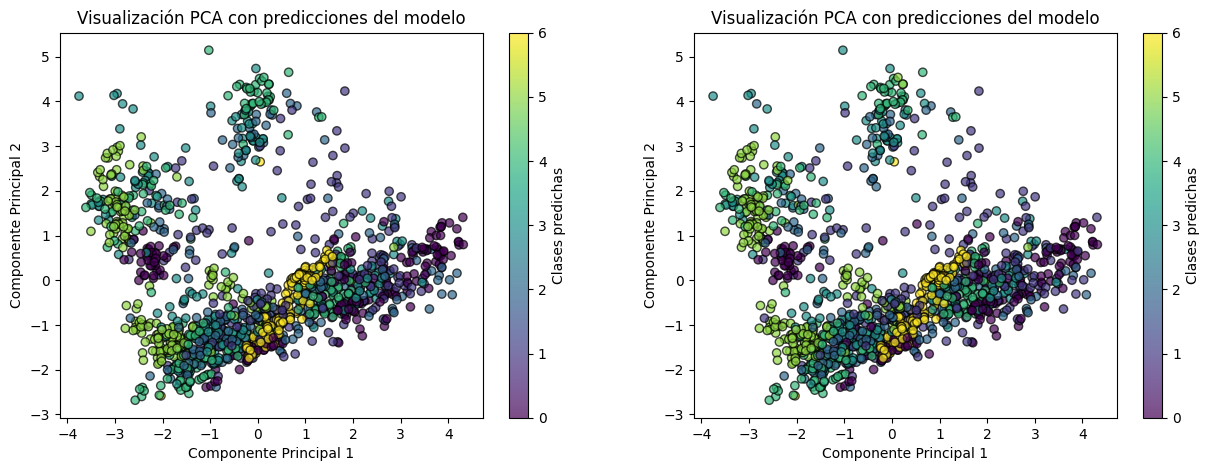

In [388]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.scatter(x_train_pca_2d[:, 0], x_train_pca_2d[:, 1], c=y_train_pca.values, cmap='viridis', edgecolor='k', alpha=0.7)
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.title("Visualización PCA con predicciones del modelo")
plt.colorbar(label="Clases predichas")
plt.plot()

plt.subplot(1,2,2)
plt.scatter(x_train_pca_2d[:, 0], x_train_pca_2d[:, 1], c=y_train_pred, cmap='viridis', edgecolor='k', alpha=0.7)
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.title("Visualización PCA con predicciones del modelo")
plt.colorbar(label="Clases predichas")
plt.plot()

(1477, 2)


KeyError: (slice(None, None, None), 0)

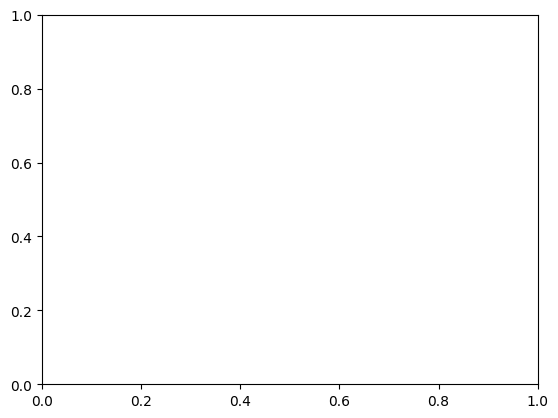

In [346]:

print(x_train_pca_2d.shape)
mglearn.plots.plot_2d_separator(pca_net, x_train_pca_2d, fill=True, alpha=.3)